In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
import warnings

from scipy.optimize import minimize, NonlinearConstraint
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

warnings.filterwarnings("ignore", category=UserWarning)

### Define the Basis functions

In [2]:
def all_basis_func(t, k_order=3):
    t = 2*(t-0.5)
    t = t.reshape(-1,1)
    # Linear with order
    linear_list = t
    for linear_order in range(2, k_order):
        temp = (t)**linear_order
        linear_list = np.concatenate([linear_list, temp], axis=1)
    # Tanh
    tanh = (np.exp(5*t)-np.exp(-5*t)) / (np.exp(5*t)+np.exp(-5*t))
    # Gaussian
    gaus = np.exp(-5*t**2)
    # Trad Exp
    trad_exp = np.exp(t/5)
    # Trad Cos
    trad_cos = np.cos(t/5)
    return np.concatenate([linear_list, gaus, trad_exp, trad_cos], axis=1)

### Lagged Variables

In [3]:
def TV_VAR_lagged(X_data, r, t_list, linear_max_order=3):
    t_train = []
    for i in range(r):
        t_train.append(t_list[i:-r+i])
    t_train = np.transpose(np.array(t_train))
    t_train_processed = all_basis_func(t_train[:, -1] + t_list[1]-t_list[0])
    for i in range(t_train.shape[1]):
        t_processed_temp = all_basis_func(t_train[:,i], k_order=linear_max_order)
        t_processed_kroned = np.array(np.kron(X_data[i], t_processed_temp[0])).reshape(1,-1)
        for j in range(1, t_train.shape[0]):
            t_kroned_temp = np.kron(X_data[i+j], t_processed_temp[j]).reshape(1,-1)
            t_processed_kroned = np.concatenate([t_processed_kroned, t_kroned_temp], axis=0)
        t_train_processed = np.concatenate([t_train_processed, t_processed_kroned], axis=1)
    return t_train_processed

### GAM

In [4]:
def linear_minimize_obj(x, A, y):
    x = x.reshape(-1,1)
    return LA.norm(A.dot(x) - y)

def GAM_constrain(x, p):
    r = int((len(x) - 1)/p)
    H = np.zeros(shape=(r, r*p + p))
    for i in range(r):
        H[i, p+i*p: p+p*(i+1)] = 1
    return np.sum(np.abs(H.dot(x)))

In [5]:
def TV_VAR_GAM(data, t_list, r, dimen_index, p=5):
    TV_VAR_data = TV_VAR_lagged(data, r, t_list)
    TV_VAR_target = data[r:, dimen_index]
    TV_VAR_constraint = NonlinearConstraint(lambda x: GAM_constrain(x, p), 0, 1)
    TV_VAR_x = minimize(linear_minimize_obj, np.ones(shape=TV_VAR_data.shape[1]), method='trust-constr',
                      args = (TV_VAR_data, TV_VAR_target.reshape(-1,1)), constraints=[TV_VAR_constraint]).x
    TVAR_raw_pred = (TV_VAR_data.dot(TV_VAR_x.reshape(-1,1))).reshape(TV_VAR_target.shape)
    return TV_VAR_x

# p is the amount of basis function
def TV_VAR_predict(TV_VAR_x_list, data_r, t_list_r, r, p, t_h, H):
    if len(TV_VAR_x_list) < p:
        print('WRONG')
    TV_VAR_data = all_basis_func(t_list_r[-1]+t_h).reshape(-1,)
    for j in range(r):
        t_processed_temp = all_basis_func(t_list_r[j])
        t_kroned_temp = np.kron(data_r[j], t_processed_temp).reshape(-1,)
        TV_VAR_data = np.concatenate([TV_VAR_data, t_kroned_temp])
    pred_res = []
    for h in range(1, H+1):
        res_temp = []
        for i in range(p):
            res_temp.append((TV_VAR_data.dot(TV_VAR_x_list[i].reshape(-1,1))))
        res_temp = np.array(res_temp).reshape(1,-1)
        pred_res.append(res_temp.reshape(-1,))
        data_r = np.concatenate([data_r[1:], res_temp], axis=0)
        TV_VAR_data = all_basis_func(t_list_r[-1]+t_h*(h+1)).reshape(-1,)
        for j in range(r):
            t_processed_temp = all_basis_func(t_list_r[j] + t_h*h)
            t_kroned_temp = np.kron(data_r[j], t_processed_temp).reshape(-1,)
            TV_VAR_data = np.concatenate([TV_VAR_data, t_kroned_temp])
    return np.array(pred_res)

### One-side Kernel Smooth

In [6]:
def kernel_weight(t, t_star, h):
    return np.exp(-(t-t_star)**2 / (2*h**2)) / np.sqrt(2*np.pi*h**2)

def A_t_star_main(Y, r, t_star):
    A = np.ones(shape=(t_star - r - 1, 1))
    Y_temp = []
    for i in range(t_star - r - 1):
        A_temp = Y[i:i+r].reshape(-1,)
        Y_temp.append(A_temp)
    return np.concatenate([A, np.array(Y_temp)], axis=1)

def OKS_constraint(x):
    H = np.array([0])
    H = np.concatenate([H, np.ones(shape=(len(x)-1,))])
    return H.dot(np.abs(x))

def one_side_KS_t_star_y_ind(Y, r, t_star, y_ind, h=0.5):
    A_t_star = A_t_star_main(Y, r, t_star)
    t_list = np.arange(r+1, t_star,1)
    Y_list_ind = Y[r+1:t_star, y_ind].reshape(-1,1)
    
    W_t_star = kernel_weight(t_list, t_star, h=h).reshape(-1,1)
    A_t_star = W_t_star*A_t_star
    Y_list_ind = W_t_star*Y_list_ind
    TVAR_constraint = NonlinearConstraint(lambda x: OKS_constraint(x), 0, 1)
    TV_VAR_x = minimize(linear_minimize_obj, np.ones(shape=A_t_star.shape[1])*0.5, method='trust-constr',
                      args = (A_t_star, Y_list_ind.reshape(-1,1)), constraints=[TVAR_constraint]).x
    TVAR_raw_pred = (A_t_star.dot(TV_VAR_x.reshape(-1,1))).reshape(Y_list_ind.shape)
    # print(mean_absolute_error(TVAR_raw_pred, Y_list_ind))
    return TV_VAR_x    

def one_side_KS_CV_main(Y, r, t_star, y_ind, h_list = np.linspace(5, 26, 21)):    
    last_mae = []
    y_temp = np.concatenate([[1], Y[-r-1:-1].reshape(-1)])
    for h in h_list:
        last_one_coef = one_side_KS_t_star_y_ind(Y[:-1], r, t_star-1, y_ind, h=h)
        last_mae.append(np.abs(y_temp @ last_one_coef - Y[-1, y_ind]))
    # print(last_mae)
    h = h_list[np.argmin(last_mae)]
    return one_side_KS_t_star_y_ind(Y, r, t_star, y_ind, h=h)

def one_side_KS_predict(Y, beta_t_star_ma, H):
    Y_pred_data = Y
    Y_pred_res, Y_pred_temp = [], []
    for k in range(Y.shape[1]):
        Y_pred_data_temp = np.concatenate([[1], Y_pred_data.reshape(-1)])
        Y_pred_temp.append(Y_pred_data_temp @ beta_t_star_ma[k])
    Y_pred_temp = np.array(Y_pred_temp)
    Y_pred_data = np.concatenate([Y_pred_data, Y_pred_temp.reshape(1,-1)], axis=0)[1:]
    Y_pred_res.append(Y_pred_temp)

    for i in range(1, H):
        Y_pred_temp = []
        for k in range(Y.shape[1]):
            Y_pred_data_temp = np.concatenate([[1], Y_pred_data.reshape(-1)])
            Y_pred_temp.append(Y_pred_data_temp @ beta_t_star_ma[k])
        Y_pred_temp = np.array(Y_pred_temp)
        Y_pred_data = np.concatenate([Y_pred_data, Y_pred_temp.reshape(1,-1)], axis=0)[1:]
        Y_pred_res.append(Y_pred_temp)
    return Y_pred_res

### Define the Traditional VAR model

In [7]:
def estimate_var_coefficients(Y, p):
    X = np.hstack([Y[p - i - 1:Y.shape[0] - i - 1] for i in range(p)])
    Y_target = Y[p:]
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    B_hat = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ (X_with_intercept.T @ Y_target)
    intercept = B_hat[0]
    A_flat = B_hat[1:].T
    A_list = [A_flat[:, i*Y.shape[1]:(i+1)*Y.shape[1]] for i in range(p)]
    return intercept, A_list

def forecast_var_p(Y_hist, A_list, intercept, h):
    p = len(A_list)
    preds = []
    Y_current = Y_hist[-p:].tolist()
    for _ in range(h):
        y_pred = intercept.copy()
        for i in range(p):
            y_pred += A_list[i] @ Y_current[-i-1]
        preds.append(y_pred)
        Y_current.append(y_pred)
        Y_current.pop(0)
    return np.array(preds)


### Define Prediction

In [8]:
def GAM_pred_H_offline(y_t_train, t_train, r_max, p, H=3):
    GAM_pred_all = []
    t_h = t_train[1] - t_train[0]
    for r in range(1,r_max):
        GAM_r = []
        for i in range(p):
            GAM_r.append(TV_VAR_GAM(y_t_train, t_train, r, i))
        GAM_pred = TV_VAR_predict(GAM_r, y_t_train[-r:], t_train[-r:], r, p, t_h, H)
        GAM_pred_all.append(GAM_pred)
    return GAM_pred_all

def OKS_pred_H_offline(y_t_train, t_train, r_max, p, H=3):
    OKS_pred_all = []
    for r in range(1,r_max):
        OKS_r = []
        for i in range(p):
            OKS_r.append(one_side_KS_CV_main(y_t_train, r, len(t_train), i))
        OKS_pred = one_side_KS_predict(y_t_train[-r:], OKS_r, H)
        OKS_pred_all.append(OKS_pred)
    return np.array(OKS_pred_all)

def VAR_pred_H_offline(y_t_train, r_max, H=3):
    VAR_pred_all = []
    for r in range(1,r_max):
        VAR_intercept, VAR_A_list = estimate_var_coefficients(y_t_train, r)
        VAR_pred_all.append(forecast_var_p(y_t_train, VAR_A_list, VAR_intercept, H))
    return VAR_pred_all

### MAE Statistics analysis

In [9]:
def MAE_vis_data(TV_VAR_pred, y_true, r=3, H=3):
    mae_res = []
    for j in range(H):
        pred_given_r_mae = []
        for r_ind in range(r):
            pred_j_H, y_t_temp = [], []
            for i in range(len(TV_VAR_pred)):
                pred_j_H.append(TV_VAR_pred[i][r_ind][j])
                y_t_temp.append(y_true[i][j])
            pred_given_r_mae.append(mean_absolute_error(pred_j_H, y_t_temp))
        mae_res.append(pred_given_r_mae)
    return mae_res

def MAE_statis(y_pred, y_true, r=3, H=3):
    mean_res, var_res, min_res, max_res = [], [], [], []
    
    for j in range(H):
        mean_r_mae, var_r_mae, min_r_mae, max_r_mae = [], [], [], []
        for r_ind in range(r):
            pred_j_H, y_t_temp = [], []
            for i in range(len(y_pred)):
                pred_j_H.append(y_pred[i][r_ind][j])
                y_t_temp.append(y_true[i][j])
            pred_j_H = np.array(pred_j_H)
            y_t_temp = np.array(y_t_temp)
            mean_r_mae.append(np.mean(np.abs(pred_j_H - y_t_temp)))
            var_r_mae.append(np.var(np.abs(pred_j_H - y_t_temp), ddof=1))
            min_r_mae.append(np.min(np.abs(pred_j_H - y_t_temp)))
            max_r_mae.append(np.max(np.abs(pred_j_H - y_t_temp)))
        mean_res.append(mean_r_mae)
        var_res.append(var_r_mae)
        min_res.append(min_r_mae)
        max_res.append(max_r_mae)
    return mean_res, var_res, min_res, max_res

### Simulations

In [10]:
def g_fun_p2(A, t):
    t = 1-t
    out = np.zeros(shape=A.shape)
    out[0,0] = np.min([A[0,0] + t, 1])
    out[0,1] = 1 - out[0,0]

    out[1,0] = np.min([A[1,0] + t, 1])
    out[1,1] = 1 - out[1,0]
    return out/2

def g_fun_p2_2(A, t):
    t = 1-t
    out = np.zeros(shape=A.shape)
    out[0,0] = np.max([A[0,0] - t, 0])
    out[0,1] = 1 - out[0,0]

    out[1,0] = np.min([A[1,0] + t, 1])
    out[1,1] = 1 - out[1,0]
    return out/2

def g_fun_p3(A, t):
    t = 1-t
    out = np.zeros(shape=A.shape)
    out[0,0] = np.min([A[0,0] + t,1])
    out[0,1] = np.min([A[0,1] + t,1])
    out[0,2] = 1 - out[0,0] - out[0,1]

    out[1,0] = np.min([A[0,0] + t,1])
    out[1,1] = np.max([A[1,1] - t,0])
    out[1,2] = 1 - out[1,0] - out[1,1]

    out[2,0] = np.max([A[0,0] - t,0])
    out[2,1] = np.min([A[0,1] + t,1])
    out[2,2] = 1 - out[2,0] - out[2,1]
    return out/2

def g_fun_p3_2(A, t):
    out = np.zeros(shape=A.shape)
    out[0,0] = np.max([A[0,0] - t,0])
    out[0,1] = np.max([A[0,1] - t,0])
    out[0,2] = 1 - out[0,0] - out[0,1]

    out[1,0] = np.max([A[0,0] - t,0])
    out[1,1] = np.min([A[1,1] + t,1])
    out[1,2] = 1 - out[1,0] - out[1,1]

    out[2,0] = np.min([A[0,0] + t,1])
    out[2,1] = np.max([A[0,1] - t,0])
    out[2,2] = 1 - out[2,0] - out[2,1]
    return out/2

In [11]:
def y_t_generate(y_0, t, p, A1_fixed, A2_fixed, A_type = 'p2'):
    eps_t = np.random.normal(0, 1, size=p)
    y_t = np.concatenate([y_0.reshape(1,-1), (y_0 + 0.1*np.random.normal(0, 1, size=p)).reshape(1,-1) ], axis=0)
    for i,j in enumerate(t[2:]):
        eps_t = 0.1*np.random.normal(0, 1, size=p)
        if A_type == 'p2':
            A1 = g_fun_p2(A1_fixed,j)
            A2 = g_fun_p2_2(A2_fixed,t[1+i])
        elif A_type == 'p3_1':
            A1 = g_fun_p3(A1_fixed,j)
            A2 = g_fun_p3_2(A2_fixed,t[1+i])
        y_t_next = y_t[-1].dot(A1) + y_t[-2].dot(A2) + eps_t
        y_t = np.concatenate([y_t, y_t_next.reshape(1,-1)], axis=0)
    return y_t

def y_t_generate2(y_0, t, p, A1_fixed, A2_fixed, A_type = 'p2'):
    eps_t = np.random.normal(0, 1, size=p)
    y_t = np.concatenate([y_0.reshape(1,-1), (y_0 + 0.1*np.random.normal(0, 1, size=p)).reshape(1,-1) ], axis=0)
    for i,j in enumerate(t[2:]):
        eps_t = 0.1*np.random.normal(0, 1, size=p)
        if A_type == 'p2':
            A1 = g_fun_p2(A1_fixed,j)
            A2 = g_fun_p2_2(A2_fixed,t[1+i])
        elif A_type == 'p3_1':
            A1 = g_fun_p3(A1_fixed,j)
            A2 = g_fun_p3_2(A2_fixed,t[1+i])
        y_t_next = y_t[-1].dot(A1) + y_t[-2].dot(A2) +t[1+i]/20+ eps_t
        y_t = np.concatenate([y_t, y_t_next.reshape(1,-1)], axis=0)
    return y_t

### Real-World application

In [ ]:
TV_VAR_data = pd.read_csv('TV_VAR_real_wd_data.cvs')
TV_VAR_data['Date_time'] = pd.to_datetime(TV_VAR_data['Date_time'])
TV_VAR_data_np = TV_VAR_data.iloc[:, 1:].to_numpy()

In [ ]:
y_t = TV_VAR_data_np
t = np.linspace(0, 1, len(y_t))
ind_1 = 1
r_max = 4
p = 3

t_h =t[1]-t[0]
GAM_pred_all, OKS_pred_all, VAR_pred_all = [], [], []
for i in tqdm(range(126)):

    GAM_pred_temp = GAM_pred_H_offline(y_t[:-126 + i], t[:-126 + i], r_max, p, H = 1)
    OKS_pred_temp = OKS_pred_H_offline(y_t[:-126 + i], t[:-126 + i], r_max, p, H = 1)
    VAR_pred_temp = VAR_pred_H_offline(y_t[:-126 + i], r_max, H=1)

    GAM_pred_all.append(GAM_pred_temp)
    OKS_pred_all.append(OKS_pred_temp)
    VAR_pred_all.append(VAR_pred_temp)

GAM_pred_all = np.array(GAM_pred_all)
OKS_pred_all = np.array(OKS_pred_all)
VAR_pred_all = np.array(VAR_pred_all)


In [28]:
GAM_pred_df = pd.read_csv('GAM_rd_126.csv')
OKS_pred_df = pd.read_csv('OKS_rd_126.csv')
TV_VAR_data = pd.read_csv('TV_VAR_real_wd_data.cvs')
TV_VAR_data['Date_time'] = pd.to_datetime(TV_VAR_data['Date_time'])
y_true = TV_VAR_data.iloc[-126:]
y_true = y_true.reset_index(drop='True')

In [ ]:
pred_GAM,pred_OKS = [], []
p = 0
r = 2
for i in range(len(GAM_pred_all)):
    pred_GAM.append(GAM_pred_all[i][r].reshape(-1,))
    pred_OKS.append(OKS_pred_all[i][r].reshape(-1,))

pred_GAM = np.array(pred_GAM)
pred_OKS = np.array(pred_OKS)

GAM_pred_df = pd.DataFrame(data=pred_GAM, columns=['VIX', 'SP500','US-1-month'])
OKS_pred_df = pd.DataFrame(data=pred_OKS, columns=['VIX', 'SP500','US-1-month'])

GAM_pred_df.to_csv('GAM_rd_126.csv', index=False)
OKS_pred_df.to_csv('OKS_rd_126.csv', index=False)

In [ ]:
GAM_MAE, OKS_MAE = [], []
for i in range(3):
    GAM_MAE.append(mean_absolute_error(y_true.iloc[:, i+1], GAM_pred_df.iloc[:,i]))
    OKS_MAE.append(mean_absolute_error(y_true.iloc[:, i+1], OKS_pred_df.iloc[:,i]))
MAE_res = np.concatenate([GAM_MAE, OKS_MAE])

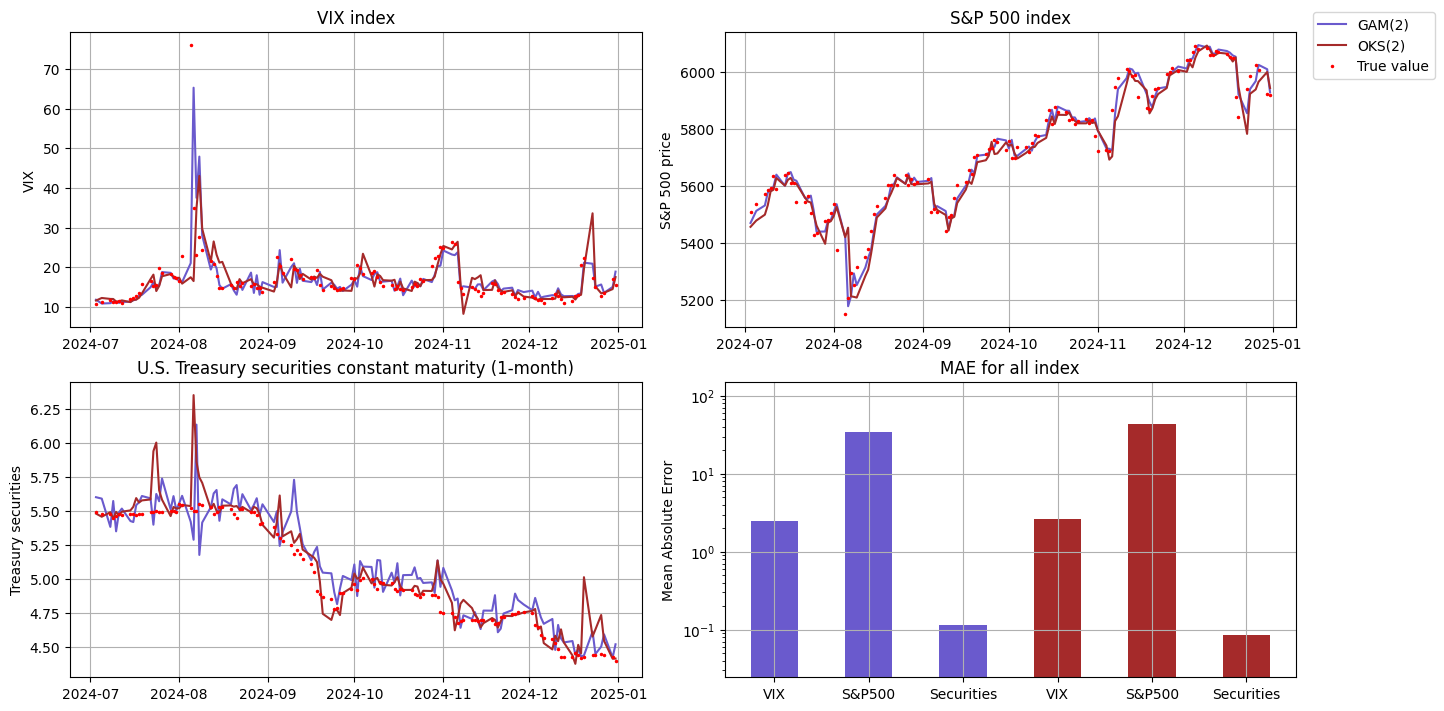

In [ ]:
fig, axs=plt.subplots(layout='constrained', nrows=2, ncols=2, figsize=(13, 7))
axs[0,0].plot(y_true['Date_time'], GAM_pred_df.iloc[:,0], label='GAM(2)', color='slateblue', linewidth=1.5)
axs[0,0].plot(y_true['Date_time'], OKS_pred_df.iloc[:,0], label='OKS(2)', color='brown', linewidth=1.5)
axs[0,0].plot(y_true['Date_time'], y_true.iloc[:,1], '.r', label='True value', ms=3)
axs[0,0].grid()
axs[0,0].set_title('VIX index')
axs[0,0].set_ylabel('VIX')

axs[0,1].plot(y_true['Date_time'], GAM_pred_df.iloc[:,1], color='slateblue', linewidth=1.5)
axs[0,1].plot(y_true['Date_time'], OKS_pred_df.iloc[:,1], color='brown', linewidth=1.5)
axs[0,1].plot(y_true['Date_time'], y_true.iloc[:,2],'.r', ms=3)
axs[0,1].grid()
axs[0,1].set_title('S&P 500 index')
axs[0,1].set_ylabel('S&P 500 price')

axs[1,0].plot(y_true['Date_time'], GAM_pred_df.iloc[:,2], color='slateblue', linewidth=1.5)
axs[1,0].plot(y_true['Date_time'], OKS_pred_df.iloc[:,2], color='brown', linewidth=1.5)
axs[1,0].plot(y_true['Date_time'], y_true.iloc[:,3], '.r', ms=3)
axs[1,0].grid()
axs[1,0].set_title('U.S. Treasury securities constant maturity (1-month)')
axs[1,0].set_ylabel('Treasury securities')

axs[1,1].bar(np.linspace(0,1,3), GAM_MAE, 0.25, color = 'slateblue')
axs[1,1].bar(np.linspace(1.5,2.5,3), OKS_MAE, 0.25, color = 'brown')
axs[1,1].set_yscale("log")
axs[1,1].set_title('MAE for all index')
axs[1,1].grid()
axs[1,1].set_xticks(np.concatenate([np.linspace(0,1,3), np.linspace(1.5,2.5,3)]), ['VIX', 'S&P500','Securities', 'VIX', 'S&P500','Securities'])
axs[1,1].set_ylabel('Mean Absolute Error')
axs[1,1].margins(y=0.2)
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))
